In [21]:
%matplotlib inline
import numpy as np
from skimage import io
from matplotlib import pylab as plt

/home/mateusz/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/mateusz/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


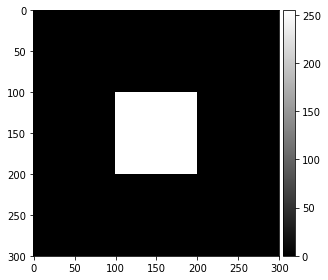

In [103]:
def Besenham(x1,y1,x2,y2,img):
    x = x1
    y = y1
    suma = 0
    if (x1<x2):
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2
    if (y1<y2):
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y1
        
    suma += img[x, y]    
        
    if (dx > dy):
        ai = (dy - dx)*2
        bi = dy * 2
        d = bi - dx
        while(x != x2):
            if (d>=0):
                x+=xi
                y+=yi
                d+=ai
            else:
                x+=xi
                d+=bi
            suma += img[x, y]
    else:
        ai = (dx - dy)*2
        bi = dx * 2
        d = bi - dy
        while(y != y2):
            if (d>=0):
                x+=xi
                y+=yi
                d+=ai
            else:
                y+=yi
                d+=bi
            suma += img[x, y]
            
    return suma
            

square_size = 300
square = np.zeros((square_size,square_size), dtype=np.float64)
square[round(square_size/3):round(2*square_size/3), round(square_size/3):round(2*square_size/3)] = 255
io.imshow(square, cmap='gray')



0.0
0.0
0.0
25500.0
25500.0
21420.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
25500.0
15555.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
25500.0
12750.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
25500.0
25500.0
25500.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
25500.0
18360.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
25500.0
13260.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
25500.0
25500.0
25500.0
255.0
0.0
0.0
0.0
0.0
0.0
0.0
25500.0
22950.0
0.0
0.0
0.0
0.0
0.0
0.0
8925.0
25500.0
25500.0
15045.0
0.0
0.0
0.0
0.0
23205.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
21675.0
25500.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
25500.0
25500.0
0.0
0.0
0.0
0.0
0.0
0.0
3825.0
25500.0
25500.0
17595.0
0.0
0.0
0.0
0.0
18360.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
18615.0
23970.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
25500.0


/home/mateusz/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/mateusz/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


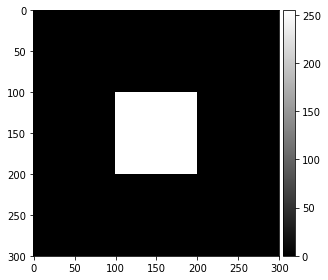

In [105]:
# Przyrost katów inc_angle emitera (położenie emitera), kąt z jakim wysyłane są fale (emiter_angle)
inc_angle, emiter_angle = 5, 15
beta = emiter_angle/2
centre = int(square_size/2)
detectors = 10

#petla - kazda pozycja emitera
for angle in range(0, 360, inc_angle):
    emiter_x = int(np.cos(angle) * (centre-5)) + centre
    emiter_y = int(np.sin(angle) * (centre-5)) + centre
    #square[emiter_x, emiter_y] = 255
    
    #petla - kazda pozycja detektora
    for a in range(detectors):
        alfa = angle + 180 - beta/2 + a*beta/(detectors-1)
        det_x = int(np.cos(alfa) * (centre-2) + centre)
        det_y = int(np.sin(alfa) * (centre-2) + centre)
        
        #Besenham
        suma = Besenham(emiter_x, emiter_y, det_x, det_y, square)
        #print(suma)
        

io.imshow(square, cmap='gray')